In [63]:
## These program is was created as result and requisite of the coursera course
##
##     Advanced Data Science with IBM   
##
####################################################################
## The main objective on this program is create a Demand Planing ML model
## for this we took the data set from kaggle called future Volume Prediction
## https://www.kaggle.com/utathya/future-volume-prediction
## The outcome is a model to predict the volume of future months.
####################################################################
##
##    Mode Definition
##

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
from sklearn.model_selection import train_test_split
#, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD, Adamax, Nadam
from tensorflow.keras.layers import TimeDistributed, Conv1D, RepeatVector, Conv2D, Conv3D

In [66]:
#Reading the file saved from  ETL file
df = pd.read_csv('dataset.csv')

In [67]:
#Analizing SKU_01
sku="SKU_01"
df_sku = df[['SKU', 'Volume', 'Avg_Max_Temp', 'Promotions']]
df_sku = df_sku.groupby(['SKU']).sum()
df_sku_sel = df[df['SKU'] == sku][['YearMonth','Volume', 'Avg_Population_2017', 'Avg_Max_Temp', 'Promotions']]
df_sku_sel = df_sku_sel.groupby(['YearMonth']).agg({ 'Volume': np.mean, 'Avg_Max_Temp' : np.mean, 'Promotions':np.mean  })


In [68]:
# funtion to serialize the data for time series. I took it from this web page
# https://www.tensorflow.org/tutorials/structured_data/time_series
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [69]:
# funtion to plot train and validation lost. 
# I took it from this web page
# https://www.tensorflow.org/tutorials/structured_data/time_series
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()
  plt.show()

In [70]:
# The data is 60 month of data. We will split is 51 month for Training, 3 for validation and 3 for test.
# We loose 3 when we convert to Univariate data  
values = df_sku_sel.values
values = values.astype('float32')
train = 50
val = 3

In [71]:
#First Way scaling all at the same time one.
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import scale, MaxAbsScaler, QuantileTransformer,  PowerTransformer 
scaller1 = MaxAbsScaler()

#scaller1 = StandardScaler()
#scaller1 = scale()
#scaller1 = QuantileTransformer()  
#scaller1 = PowerTransformer()
#scaller1 = MinMaxScaler()
#scaller1 = QuantileTransformer(output_distribution='normal',random_state=0)
#scaller1 = PowerTransformer(method='box-cox', standardize=False)

std1 = values[:train,:].reshape(values[:train,:].shape[0],values[:train,:].shape[1])
scaled1_train = scaller1.fit_transform(std1)
std1 = values[train:,:].reshape(values[train:,:].shape[0],values[train:,:].shape[1])
scaled1_test = scaller1.transform(std1)
scaled1 = np.concatenate((scaled1_train,scaled1_test), axis = 0 )

In [72]:
# Using time step 3 with 1 output
history_size = 3
target_size = 0

# Preparing Dimension of Volume
X, y = univariate_data(scaled1[:,0], 0, len(scaled1), history_size, target_size)
y = scaled1[3:,0]
X1, y1 = univariate_data(scaled1[:,1], 0, len(scaled1), history_size, target_size)
X2, y2 = univariate_data(scaled1[:,2], 0, len(scaled1), history_size, target_size)
X = np.concatenate((X,X1,X2), axis = 2 )

In [73]:
# The data is 60 month of data. We will split is 51 month for Training, 6 for validation and 6 for test.
#X, y = values[:,:-1], values[:,-1:]
x_train_uni, y_train_uni = X[: train] , y[:train]
x_val_uni, y_val_uni = X[train: train + val ] , y[train: train + val]
x_test_uni, y_test_uni = X[train + val:] , y[train + val:]

In [74]:
# GRU->GRU->GRU using mae
model = Sequential()
model.add(GRU(300, activation='relu',return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(GRU(200, activation='relu', return_sequences=True ))
model.add(GRU(100, activation='relu', return_sequences=True ))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 3, 300)            274500    
_________________________________________________________________
gru_9 (GRU)                  (None, 3, 200)            301200    
_________________________________________________________________
gru_10 (GRU)                 (None, 3, 100)            90600     
_________________________________________________________________
gru_11 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 51        
Total params: 689,151
Trainable params: 689,151
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.7257510081807251
mse=  0.0024237246
rmse=  0.04923134


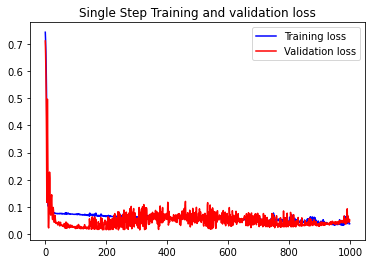

In [75]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
#Getting mse, r2_score, mse and rmse for the training set. The results looks good on the trainign set.
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')


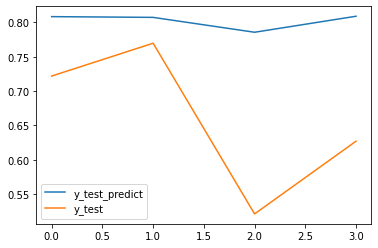

r2_Score=  -2.0906034461544944
mse=  0.027977439
rmse=  0.16726458


In [76]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [77]:
# GRU->GRU->GRU using mse
model = Sequential()
model.add(GRU(300, activation='relu',return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(GRU(200, activation='relu', return_sequences=True ))
model.add(GRU(100, activation='relu', return_sequences=True ))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, 3, 300)            274500    
_________________________________________________________________
gru_13 (GRU)                 (None, 3, 200)            301200    
_________________________________________________________________
gru_14 (GRU)                 (None, 3, 100)            90600     
_________________________________________________________________
gru_15 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 51        
Total params: 689,151
Trainable params: 689,151
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.6840388013122755
mse=  0.0027923638
rmse=  0.052842822


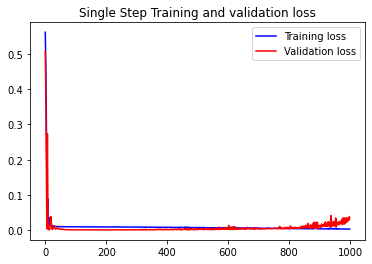

In [78]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
#Getting mse, r2_score, mse and rmse for the training set. The results looks good on the trainign set.
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

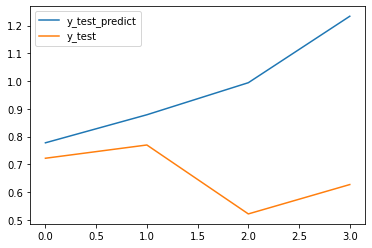

r2_Score=  -15.758694487311377
mse=  0.15170673
rmse=  0.38949546


In [79]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [80]:
# LSTM->LSTM->LSTM using mae
model = Sequential()
model.add(LSTM(300, activation='relu',return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', return_sequences=True ))
model.add(LSTM(100, activation='relu', return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_44 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_45 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_46 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.2262444526300822
mse=  0.0068382043
rmse=  0.082693435


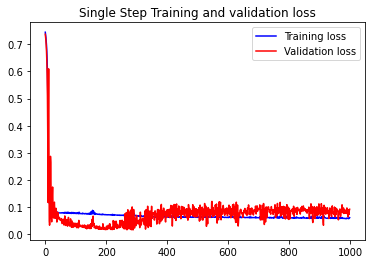

In [81]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

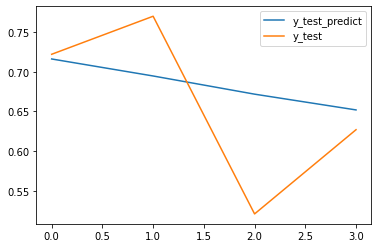

r2_Score=  0.20039507480472996
mse=  0.007238359
rmse=  0.085078545


In [82]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [83]:
# LSTM(300)->LSTM(200)->LSTM(100)->LSTM(50) using mse
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', return_sequences=True ))
model.add(LSTM(100, activation='relu', return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_48 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_49 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_50 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.3652474878590096
mse=  0.00560974
rmse=  0.0748982


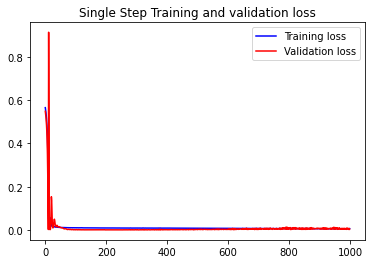

In [84]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

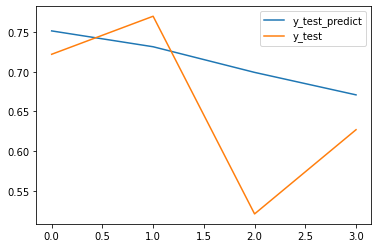

r2_Score=  0.00843316617709955
mse=  0.008976079
rmse=  0.09474217


In [85]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [86]:
# LSTM(300)->LSTM(200)->LSTM(100)->LSTM(50) using mse and Dropout =0.2
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.2,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_52 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_53 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_54 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.4177789423490045
mse=  0.0051454837
rmse=  0.07173203


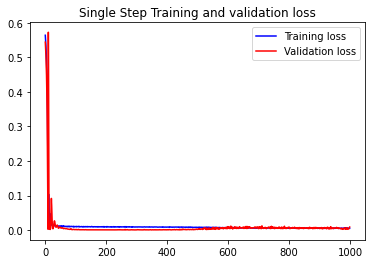

In [87]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

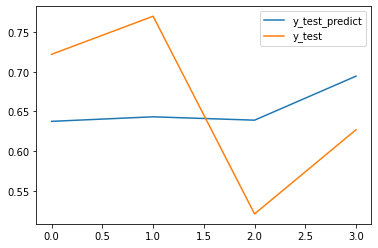

r2_Score=  -0.14634686325936097
mse=  0.010377212
rmse=  0.10186861


In [88]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [89]:
# LSTM(300)->LSTM(200)->LSTM(100)->LSTM(50) using mse and Dropout =0.3
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.3,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_56 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_57 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_58 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.3628864023795476
mse=  0.005630606
rmse=  0.07503736


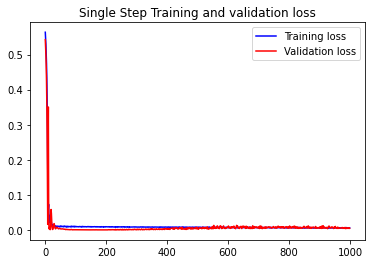

In [90]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

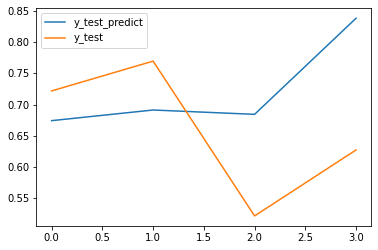

r2_Score=  -1.2018032389623063
mse=  0.019931646
rmse=  0.14117949


In [91]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [92]:
# LSTM(300)->LSTM(300)->LSTM(300) -> LTSM(300) using mse
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(300, activation='relu', return_sequences=True ))
model.add(LSTM(300, activation='relu', return_sequences=True ))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_60 (LSTM)               (None, 3, 300)            721200    
_________________________________________________________________
lstm_61 (LSTM)               (None, 3, 300)            721200    
_________________________________________________________________
lstm_62 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 301       
Total params: 2,528,701
Trainable params: 2,528,701
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.506939968005417
mse=  0.0043575065
rmse=  0.066011414


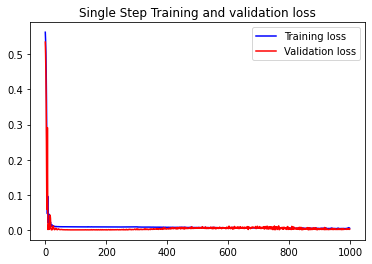

In [93]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

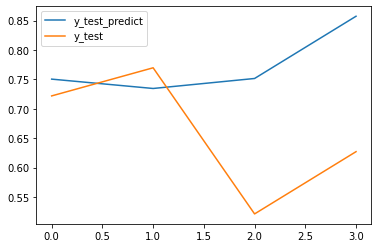

r2_Score=  -1.9858872939672336
mse=  0.027029503
rmse=  0.16440652


In [94]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [95]:
# LSTM(300)->LSTM(300)->LSTM(200) -> LTSM(200) using mae
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(300, activation='relu', return_sequences=True ))
model.add(LSTM(200, activation='relu', return_sequences=True ))
model.add(LSTM(200, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_64 (LSTM)               (None, 3, 300)            721200    
_________________________________________________________________
lstm_65 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_66 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 201       
Total params: 1,807,801
Trainable params: 1,807,801
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.3765839861077481
mse=  0.005509551
rmse=  0.07422635


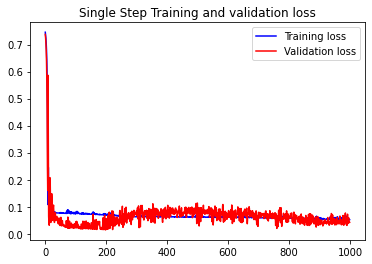

In [96]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

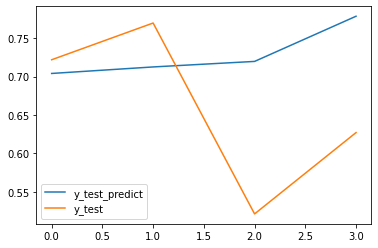

r2_Score=  -0.8207074559590088
mse=  0.016481807
rmse=  0.12838149


In [97]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [98]:
# LSTM(300)->LSTM(200)->LSTM(100)->LSTM(50) using mse and Dropout =0.4
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.4,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_68 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_69 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_70 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.39874412120217084
mse=  0.0053137075
rmse=  0.072895184


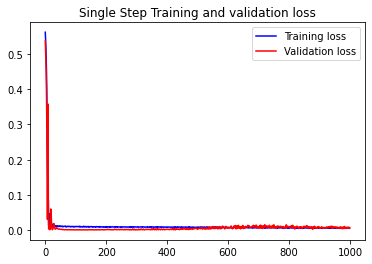

In [99]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

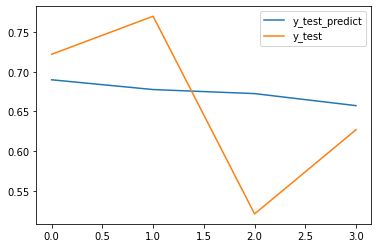

r2_Score=  0.0801203569636213
mse=  0.008327137
rmse=  0.09125315


In [100]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [101]:
# LSTM(300)->LSTM(200)->LSTM(100)->LSTM(50) using mae and Dropout =0.3
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.3,  return_sequences=True ))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_72 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_73 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_74 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 51        
Total params: 916,251
Trainable params: 916,251
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.24968113686945492
mse=  0.006631078
rmse=  0.08143143


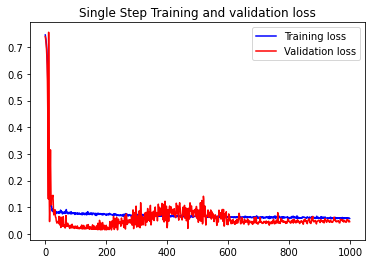

In [102]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

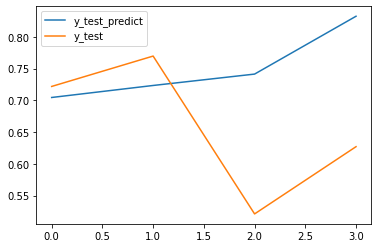

r2_Score=  -1.5700105564658995
mse=  0.023264814
rmse=  0.15252808


In [103]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [104]:
# LSTM(300)->LSTM(200) -> LSTM(50) using mse and Dropout =0.3
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.3,  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_76 (LSTM)               (None, 3, 200)            400800    
_________________________________________________________________
lstm_77 (LSTM)               (None, 50)                50200     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 51        
Total params: 815,851
Trainable params: 815,851
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.5094679830059474
mse=  0.004335165
rmse=  0.06584197


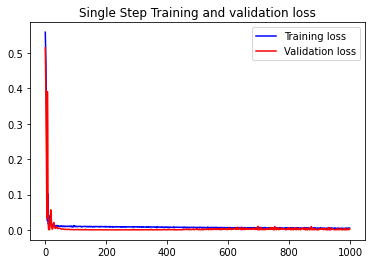

In [105]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

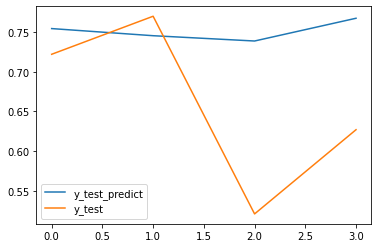

r2_Score=  -0.8921683228579291
mse=  0.0171287
rmse=  0.13087666


In [106]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [107]:
# LSTM(300)->LSTM(200)->RepeatVector(),  -> LSTM(100) -> LSTM(50) using mse and Dropout =0.3
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(200, activation='relu', dropout=0.3 ))
model.add(RepeatVector(3))
model.add(LSTM(100, activation='relu',  return_sequences=True ))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_79 (LSTM)               (None, 200)               400800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
lstm_80 (LSTM)               (None, 3, 100)            120400    
_________________________________________________________________
lstm_81 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dense_24 (Dense)             (None, 1)               

r2_Score=  0.49680121687369583
mse=  0.0044471095
rmse=  0.06668665


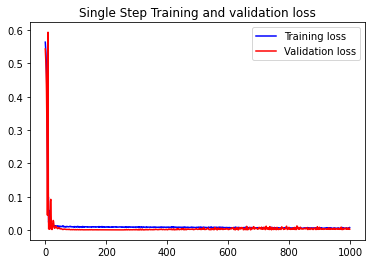

In [108]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

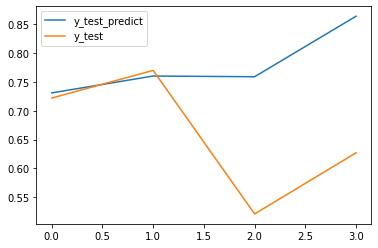

r2_Score=  -2.1060844794681115
mse=  0.028117578
rmse=  0.16768298


In [109]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))

In [110]:
# LSTM(300)->LSTM(300)->LSTM(300) -> LTSM(300) using mse
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(x_train_uni.shape[1], x_train_uni.shape[2])))
model.add(LSTM(300, activation='relu', dropout=0.3 , return_sequences=True ))
model.add(LSTM(300, activation='relu', return_sequences=True ))
model.add(LSTM(300, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', 'mae', 'mse'])
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 3, 300)            364800    
_________________________________________________________________
lstm_83 (LSTM)               (None, 3, 300)            721200    
_________________________________________________________________
lstm_84 (LSTM)               (None, 3, 300)            721200    
_________________________________________________________________
lstm_85 (LSTM)               (None, 300)               721200    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 301       
Total params: 2,528,701
Trainable params: 2,528,701
Non-trainable params: 0
_________________________________________________________________
None


r2_Score=  0.5767299361457389
mse=  0.0037407256
rmse=  0.06116147


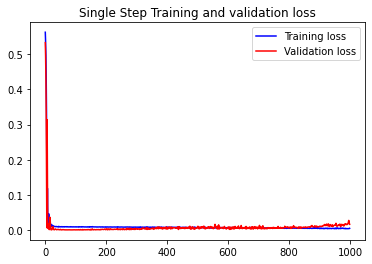

In [111]:
n_epoch = 1000
# train LSTM
history = model.fit(x_train_uni, y_train_uni, epochs=n_epoch, verbose=0, validation_data=(x_val_uni, y_val_uni))
# evaluate
result = model.predict(x_train_uni, verbose=0)
mse =mean_squared_error(y_train_uni, result.reshape(result.shape[0]))
print('r2_Score= ', r2_score(y_train_uni, result.reshape(result.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))
plot_train_history(history,
                   'Single Step Training and validation loss')

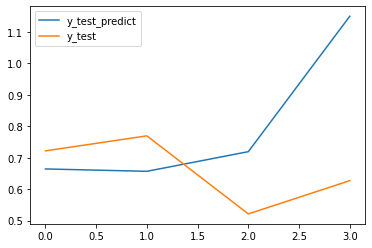

r2_Score=  -8.089101604361494
mse=  0.082278356
rmse=  0.28684205


In [112]:
# Plotting the prediction of training and test set. 
result_t = model.predict(x_test_uni, verbose=0)
plt.plot(result_t.reshape(result_t.shape[0]), label ="y_test_predict")
plt.plot(y_test_uni,label ="y_test" )
plt.legend()
plt.show()

#Getting mse, r2_score, mse and rmse for the training set the numbers are not performing as good as training set. 
mse = mean_squared_error(y_test_uni, result_t.reshape(result_t.shape[0]))
print('r2_Score= ', r2_score(y_test_uni, result_t.reshape(result_t.shape[0])))
print('mse= ', mse)
print('rmse= ', np.sqrt(mse))